# DRF of CNS-data

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.colors import LogNorm
from sklearn.utils import shuffle
from itertools import groupby 
from matplotlib.figure import figaspect

# package developed for the analysis
from world_viewer.cns_world import CNSWorld
from world_viewer.glasses import Glasses

# DTU Data Wrapper
from sensible_raw.loaders import loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jakob/Dokumente/Uni/Masterarbeit/Auswertung/DTU/reviewed version


ModuleNotFoundError: No module named 'sensible_raw'

## 1) Load and Prepare Data

In [2]:
# load data for analysis
cns = CNSWorld()
cns.load_world(opinions = ['fitness'], read_cached = False, stop=False, write_pickle = False, continous_op=False)

# load analysis tools
cns_glasses = Glasses(cns)

# remove not needed data in order to save mermory
cns.d_ij = None 

Process opinion data for variable: fitness


In [3]:
# set analysis parameters
analysis = 'expo_frac'
opinion_type = "op_fitness"
binning = True
n_bins = 10
save_plots = True
show_plot = True

In [14]:
4.1_CopenhagenDataRelativeExposure.ipynb# load previously calculated exposure instead of recalculate it
exposure = pd.read_pickle("tmp/fitness_exposure_tx7.pkl")

# alternative: recalculate exposure value
# exposure = cns_glasses.calc_exposure("expo_frac", "op_fitness", exposure_time = 7)

In [15]:
# filter by degre
degree = exposure.groupby("node_id").n_nbs.mean().to_frame("avg").reset_index()
exposure = exposure.loc[degree.loc[degree.avg >= 4,"node_id"]]
exposure = exposure.loc[exposure.n_nbs_mean > 1/7]

In [16]:
# cut time series in time slices: spring + summer

exposure.reset_index(inplace=True)
start_spring = "2014-02-01"
end_spring = "2014-04-30"
exposure_spring = exposure.loc[(exposure.time >= pd.to_datetime(start_spring)) & (exposure.time <= pd.to_datetime(end_spring))].copy()

start_summer = "2014-07-01"
end_summer = "2014-09-30"
exposure_summer = exposure.loc[(exposure.time >= pd.to_datetime(start_summer)) & (exposure.time <= pd.to_datetime(end_summer))].copy()

exposure_spring.set_index(['node_id','time'],inplace=True)
exposure_summer.set_index(['node_id','time'],inplace=True)
exposure.set_index(['node_id','time'],inplace=True)

In [17]:
# column "exposure" equals relative exposure
# column "n_influencer_summed" equals absolute exposure
# use absolute exposure for further calculations

exposure.rename(columns={"exposure":"exposure_old", "n_influencer_summed":"exposure"},inplace=True)
exposure_spring.rename(columns={"exposure":"exposure_old", "n_influencer_summed":"exposure"},inplace=True)
exposure_summer.rename(columns={"exposure":"exposure_old", "n_influencer_summed":"exposure"},inplace=True)

In [18]:
# calculate if nodes changed trait after experiencing a certain exposure
# save value as column "op_change" (bool)

data_spring, expo_agg_spring = cns_glasses.opinion_change_per_exposure(exposure_spring, opinion_type, opinion_change_time = 1)
data_summer, expo_agg_summer = cns_glasses.opinion_change_per_exposure(exposure_summer, opinion_type, opinion_change_time = 1)
data_full, expo_agg_full = cns_glasses.opinion_change_per_exposure(exposure, opinion_type, opinion_change_time = 1)

INFO: Calc op-change
INFO: Calc op-change
INFO: Calc op-change


In [9]:
# save calculated values on hard drive
expo_agg_spring.to_pickle("tmp/final/exposure_filtered_spring.pkl")

## 2) Plot Dose Response Functions (FIG.: 4.9)

<IPython.core.display.Javascript object>


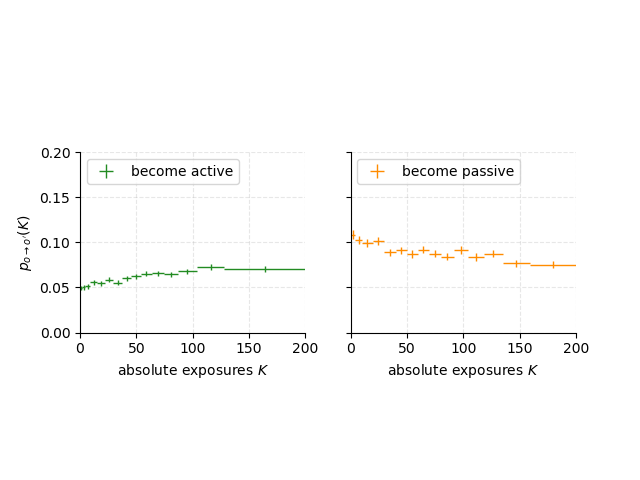

/home/lochnerpik@gmail.com/master/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))
/home/lochnerpik@gmail.com/master/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


(<Figure size 640x480 with 2 Axes>,
 <ErrorbarContainer object of 3 artists>)

In [9]:
# plot drf for full timeseries

fig, ax = plt.subplots(1,2,subplot_kw = {"adjustable":'box', "aspect":200/0.25})
cns_glasses.output_folder = "final/"
suffix = "_full"
data = data_full[data_full.exposure <= 200]
bin_width=1
q_binning=True
bin_width=5
n_bins=15
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == True], "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=False, show_plot=show_plot, y_lower_lim=0, y_upper_lim = 0.2, fig=fig, ax=ax[0], label="become active", q_binning = q_binning, \
            loglog=False, step_plot=True, color="forestgreen", suffix=suffix,x_lim=200)
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == False], "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=True, show_plot=show_plot, y_lower_lim=0, y_upper_lim = 0.2, fig=fig, ax=ax[1], label="become passive", loglog=False, \
            q_binning=q_binning, step_plot=True, color="darkorange", suffix=suffix,x_lim=200)

<IPython.core.display.Javascript object>


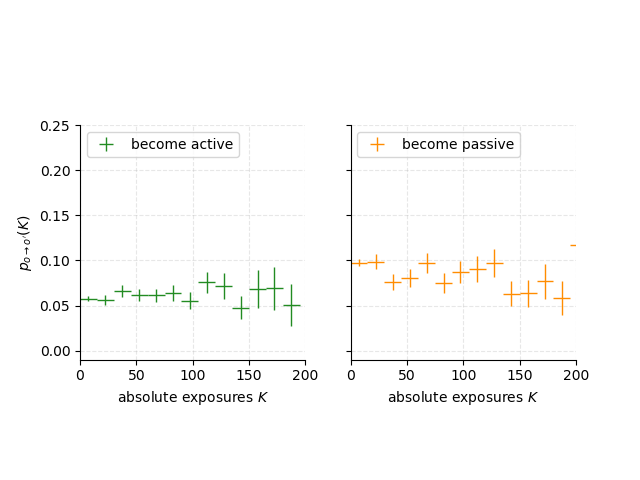

/home/lochnerpik@gmail.com/master/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


(<Figure size 640x480 with 2 Axes>,
 <ErrorbarContainer object of 3 artists>)

In [12]:
# plot drf for summer timeseries

fig, ax = plt.subplots(1,2,subplot_kw = {"adjustable":'box', "aspect":200/0.25})
cns_glasses.output_folder = "final/"
suffix = "_summer"
data = data_summer[data_summer.exposure <= 200]
q_binning=False
bin_width=15
n_bins=20
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == True].dropna(), "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=False, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.25, fig=fig, ax=ax[0], label="become active", q_binning = q_binning, loglog=False, step_plot=True, color="forestgreen", suffix=suffix,x_lim=200)
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == False].dropna(), "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=True, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.25, fig=fig, ax=ax[1], label="become passive", loglog=False, q_binning=q_binning, step_plot=True, color="darkorange", suffix=suffix,x_lim=200)

<IPython.core.display.Javascript object>


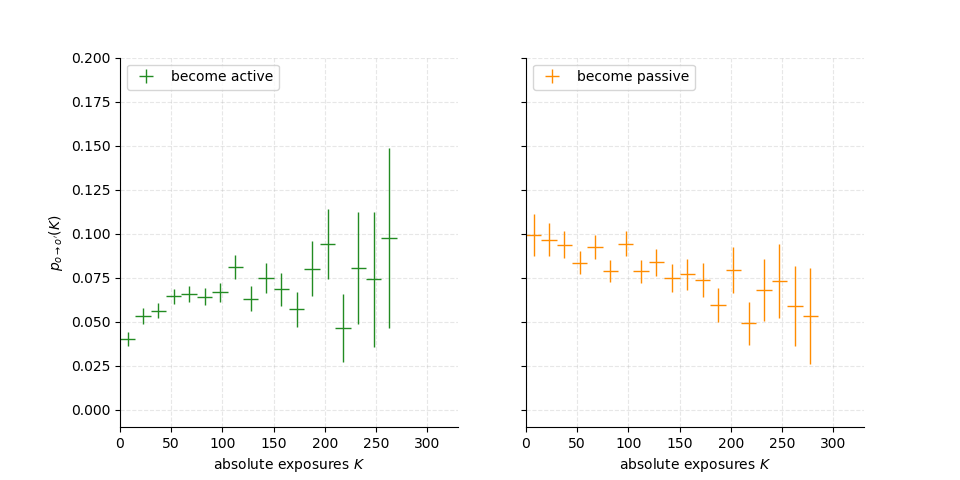

/home/lochnerpik@gmail.com/master/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


In [27]:
# plot drf for spring timeseries

x_max = 330
w, h = figaspect(0.5)
fig, ax = plt.subplots(1,2,figsize=(w,h))
cns_glasses.output_folder = "final/"
suffix = "_spring"
data = data_spring[data_spring.exposure <= x_max]
q_binning=False
bin_width=15
n_bins=15
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == True], "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=False, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.2, fig=fig, ax=ax[0], label="become active", \
            q_binning = q_binning, loglog=False, step_plot=True, color="forestgreen", suffix=suffix, x_lim=x_max)
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == False], "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=True, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.2, fig=fig, ax=ax[1], label="become passive", loglog=False, \
            q_binning=q_binning, step_plot=True, color="darkorange", suffix=suffix, x_lim=x_max)


fig.savefig("tmp/final/empirical_drfs.pdf" , bbox_inches='tight')

<IPython.core.display.Javascript object>


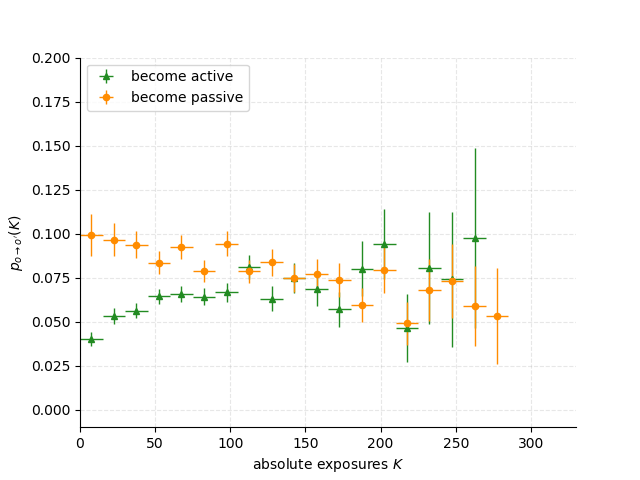

/home/lochnerpik@gmail.com/master/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'
  seen=seen, canon=canonical, used=seen[-1]))


In [31]:
x_max = 330
fig, ax = plt.subplots()
cns_glasses.output_folder = "final/"
suffix = "_spring"
data = data_spring[data_spring.exposure <= x_max]
q_binning=False
bin_width=15
n_bins=15
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == True], "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=False, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.2, fig=fig, ax=ax, label="become active", \
            q_binning = q_binning, loglog=False, step_plot=True, color="forestgreen", suffix=suffix, x_lim=x_max,marker="^", markersize=5)
fig.savefig("tmp/final/empirical_drf_1.pdf" , bbox_inches='tight')
cns_glasses.plot_opinion_change_per_exposure_number(data[data.op_fitness == False], "expo_nmb", binning, n_bins=n_bins, bin_width=bin_width, \
            save_plots=True, show_plot=show_plot, y_lower_lim=-0.01, y_upper_lim = 0.2, fig=fig, ax=ax, label="become passive", loglog=False, \
            q_binning=q_binning, step_plot=True, color="darkorange", suffix=suffix, x_lim=x_max, marker=".")
fig.savefig("tmp/final/empirical_drf_2.pdf" , bbox_inches='tight')

## 3) Plot Distribution of the Absolute Exposure (FIG.: 4.10)

In [14]:
expo = expo_agg_spring[expo_agg_spring.op_fitness==True].reset_index()

#expo = expo.loc[(expo.time > "2013-09-01") & (expo.time < "2014-09-01")]
#expo.time = expo.time.dt.dayofyear
expo.time = expo.time.astype("int")
mean_expo = expo.groupby("time").exposure.mean().to_frame("mean exposure").reset_index()
mean_expo.set_index("time",inplace=True)

<IPython.core.display.Javascript object>


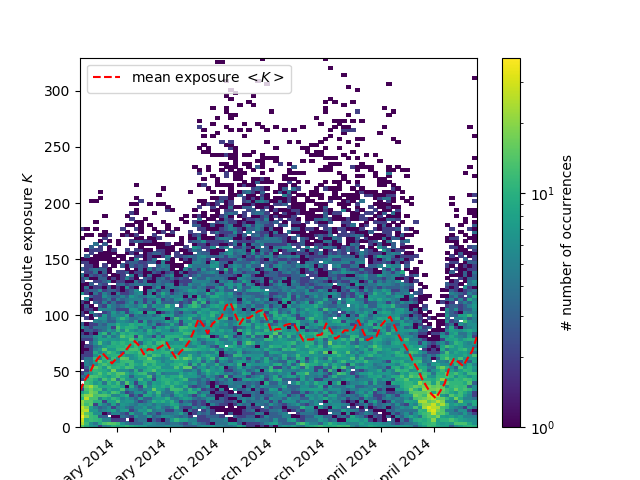

<IPython.core.display.Javascript object>


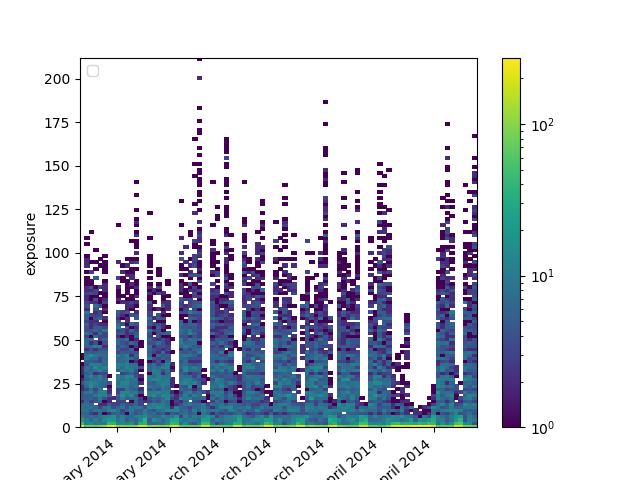

No handles with labels found to put in legend.


In [16]:
fig,ax = plt.subplots()
expo.dropna(inplace=True)
#expo = expo[expo.exposure < 250]
plot = ax.hist2d(expo.time,expo.exposure,norm=LogNorm(), bins = [len(expo.time.unique())
,120])#, vmin=1, vmax=100)
expo.groupby("time").exposure.mean().plot(label=r"mean exposure $<K>$",color="red",linestyle="--")
ax.legend(loc="upper left")
ax.set_xlabel("time")
ax.set_ylabel(r"absolute exposure $K$")
ax.set_xticklabels(pd.to_datetime(ax.get_xticks()).strftime('%d. %B %Y'), rotation=40, ha="right")
cbar = fig.colorbar(plot[3])
cbar.set_label('# number of occurrences')
fig.savefig("tmp/final/abs_expo_distrib_spring.pdf",bbox_inches='tight')
